In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import add
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import random
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Data/movies.csv")
df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [3]:
ratings = pd.read_csv("Data/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


# Question 1

In [4]:
len([df['genres'] != "(no genres listed)"])

1

In [5]:
df = df[df['genres'] != "(no genres listed)"]

In [6]:
# Séparer les genres et compter les occurrences
genres_split = df['genres'].str.split('|').explode()
genre_counts = genres_split.value_counts()

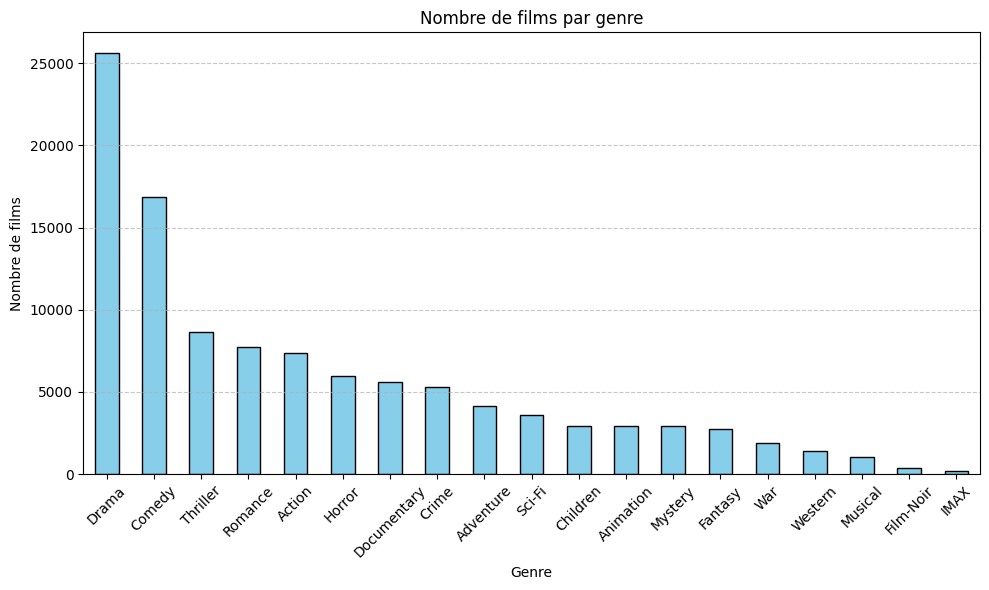

In [7]:
# Tracer le diagramme en bâtons
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre de films par genre")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

# Question 2

In [8]:
ratings = ratings[ratings['movieId'].isin(df['movieId'])]

In [9]:
initial_size = ratings.shape[0]
# Compter le nombre de films évalués par chaque utilisateur
user_ratings_count = ratings.groupby("userId").size()

# Filtrer les utilisateurs ayant évalué au moins 1000 films
users_above_threshold = user_ratings_count[user_ratings_count >= 2500].index
ratings = ratings[ratings["userId"].isin(users_above_threshold)]

# Sauvegarder le fichier réduit
ratings.to_csv("ratings_filtered_1000.csv", index=False)

# Afficher quelques statistiques
filtered_size = ratings.shape[0]
reduction_percentage = 100 * (1 - filtered_size / initial_size)

print(f"Taille initiale : {initial_size} lignes")
print(f"Taille après réduction : {filtered_size} lignes")
print(f"Réduction : {reduction_percentage:.2f}%")


Taille initiale : 24973468 lignes
Taille après réduction : 788375 lignes
Réduction : 96.84%


In [10]:
# Supprimer les lignes de ratings avec des films non listés
filtered_ratings = ratings[ratings['movieId'].isin(df['movieId'])]


In [11]:
# Remplacer les valeurs non entières dans les ratings
filtered_ratings['rating'] = filtered_ratings['rating'].replace({5.5: 5, 4.5: 4, 3.5: 3, 2.5: 2, 1.5: 1, 0.5: 1})

In [12]:
# Exporter les nouveaux fichiers
df.to_csv("movies1.csv", index=False)
filtered_ratings.to_csv("ratings1.csv", index=False)

# Question 3

In [13]:
# Charger les données des films filtrés
movies = pd.read_csv("movies1.csv")

In [14]:
# Séparer les genres en une liste pour chaque film
movies['genres'] = movies['genres'].str.split('|')

In [15]:
# Obtenir la liste de tous les genres uniques
unique_genres = sorted(set(genre for genres in movies['genres'] for genre in genres))

# Construire la matrice binaire
binary_matrix = pd.DataFrame(0, index=movies['movieId'], columns=unique_genres)

for idx, genres in zip(movies['movieId'], movies['genres']):
    binary_matrix.loc[idx, genres] = 1

In [16]:
# Ajouter le titre des films 
binary_matrix['title'] = movies.set_index('movieId')['title']

In [17]:
# Réorganiser les colonnes pour avoir 'title' en premier 
binary_matrix = binary_matrix[['title'] + unique_genres]


In [18]:
binary_matrix.head()

,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Exporter la matrice binaire
binary_matrix.to_csv("content_matrix.csv", index_label="movieId")


# Question 4

In [20]:
# Supprimer la colonne 'title' de la matrice de contenu 
binary_matrix = binary_matrix.drop(columns=['title'], errors='ignore')

In [21]:
# Créer une liste pour stocker les profils utilisateurs
user_profiles = {}

# Parcourir chaque utilisateur
for user_id, group in ratings.groupby('userId'):
    # Extraire les films notés par cet utilisateur
    rated_movie_ids = group['movieId']
    ratings_given = group['rating']
    
    # Filtrer les vecteurs des films notés dans la matrice de contenu
    user_content = binary_matrix.loc[rated_movie_ids].values
    
    # Calculer le profil utilisateur en combinant linéairement
    profile = np.dot(ratings_given.values, user_content)
    
    # Normaliser le profil utilisateur
    profile_norm = profile / np.linalg.norm(profile) if np.linalg.norm(profile) != 0 else profile
    
    # Sauvegarder dans le dictionnaire
    user_profiles[user_id] = profile_norm

In [22]:
user_profiles

{548: array([0.39149579, 0.17170467, 0.02149882, 0.04751468, 0.4107075 ,
        0.23946026, 0.00074331, 0.50350693, 0.1044065 , 0.0058893 ,
        0.20515363, 0.0395098 , 0.0125791 , 0.11498438, 0.16169857,
        0.15723871, 0.46268204, 0.04334071, 0.01412289]),
 847: array([0.12202852, 0.12812994, 0.05617086, 0.05503864, 0.31331136,
        0.16052411, 0.07843792, 0.84608535, 0.07906693, 0.02717336,
        0.0483711 , 0.01163674, 0.04327609, 0.08334422, 0.22839461,
        0.06415932, 0.18650235, 0.07529285, 0.03931331]),
 1748: array([0.31285174, 0.22678923, 0.05105763, 0.08280954, 0.48462319,
        0.17933816, 0.04151084, 0.62287481, 0.0893155 , 0.00190936,
        0.02991327, 0.0392479 , 0.03408557, 0.06590819, 0.26285487,
        0.11887518, 0.28336278, 0.06626177, 0.02602383]),
 2177: array([0.19303789, 0.16112065, 0.03222413, 0.07996846, 0.50124964,
        0.15524578, 0.01468719, 0.68380921, 0.07786402, 0.02262266,
        0.07032314, 0.00618177, 0.08237978, 0.08286205, 

# Question 5

In [23]:
# Diviser les données en deux parties (80% pour l'apprentissage, 20% pour l'évaluation)
ratings_apprentissage, ratings_evaluation = train_test_split(ratings, test_size=0.2, random_state=42)

# Exporter les deux sous-ensembles
ratings_apprentissage.to_csv("ratings_apprentissage.csv", index=False)
ratings_evaluation.to_csv("ratings_evaluation.csv", index=False)

# Afficher un aperçu des fichiers créés
print(f"Taille des données d'apprentissage : {ratings_apprentissage.shape}")
print(f"Taille des données d'évaluation : {ratings_evaluation.shape}")

Taille des données d'apprentissage : (630700, 4)
Taille des données d'évaluation : (157675, 4)


# Question 6

In [29]:
# number of neighbors of user
N_NEIGHBORS = 10

# number of recommendations
N_RECOMMENDATIONS = 5

In [39]:
ratings_evaluation

,userId,movieId,rating,timestamp
5391820,34987,90933,3.5,1333329285
6158096,39896,3301,3.0,1135325768
19182842,124482,135143,4.0,1548596981
23587377,153086,56171,4.0,1494520945
4685178,30643,1170,2.0,1156938046
...,...,...,...,...
21132789,137293,82194,3.5,1454622300
6162068,39905,1587,3.0,874537687
22187353,144301,5139,4.0,1013654249
16922884,109731,6170,3.0,1080579276


In [28]:
import pandas as pd
import numpy as np

# Initialiser les variables pour les évaluations estimées et réelles
estimated_ratings = []
true_ratings = []
user_similarity = {}

# Charger les données d'apprentissage et d'évaluation
train_set = ratings_apprentissage  # Assurez-vous que cette variable est un DataFrame
test_set = ratings_evaluation      # Assurez-vous que cette variable est un DataFrame

# Calcul de la matrice de similarité entre les utilisateurs
unique_users = train_set['userId'].unique()
for user_u in unique_users:
    for user_v in unique_users:
        if user_u != user_v:
            # Films évalués par user_u et user_v
            ratings_u = train_set[train_set['userId'] == user_u]
            ratings_v = train_set[train_set['userId'] == user_v]

            # Identifier les films communs
            common_movies = set(ratings_u['movieId']).intersection(set(ratings_v['movieId']))

            if len(common_movies) > 0:
                # Ratings des films communs pour les deux utilisateurs
                ratings_u_common = ratings_u[ratings_u['movieId'].isin(common_movies)]['rating'].values
                ratings_v_common = ratings_v[ratings_v['movieId'].isin(common_movies)]['rating'].values

                # Moyennes des évaluations
                ru = ratings_u_common.mean()
                rv = ratings_v_common.mean()

                # Calcul de la similarité
                numerateur = np.sum((ratings_u_common - ru) * (ratings_v_common - rv))
                denominateur1 = np.sqrt(np.sum((ratings_u_common - ru) ** 2))
                denominateur2 = np.sqrt(np.sum((ratings_v_common - rv) ** 2))

                similarity = numerateur / (denominateur1 * denominateur2) if denominateur1 > 0 and denominateur2 > 0 else 0
                user_similarity[(user_u, user_v)] = similarity

# Prédire les évaluations
for _, row in test_set.iterrows():
    target_user = row['userId']
    target_movie = row['movieId']
    true_rating = row['rating']

    # Trouver les utilisateurs qui ont évalué le film cible
    neighbors = train_set[train_set['movieId'] == target_movie]
    neighbors = neighbors[neighbors['userId'] != target_user]

    # Calculer la note estimée
    numerateur = 0
    denominateur = 0
    for _, neighbor_row in neighbors.iterrows():
        neighbor_user = neighbor_row['userId']
        similarity = user_similarity.get((target_user, neighbor_user), 0)
        numerateur += similarity * neighbor_row['rating']
        denominateur += abs(similarity)
    
    estimated_rating = numerateur / denominateur if denominateur > 0 else train_set[train_set['userId'] == target_user]['rating'].mean()
    
    # Stocker les résultats
    estimated_ratings.append(estimated_rating)
    true_ratings.append(true_rating)

# Calcul de l'erreur moyenne absolue
mae = np.mean(np.abs(np.array(estimated_ratings) - np.array(true_ratings)))
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 3.03803722591


In [56]:
def recommend_items_user_based(user_id, top_n=5):
    """
    Recommande des items pour un utilisateur donné en utilisant la similarité entre utilisateurs.
    """
    # Trouver les films que l'utilisateur cible n'a pas encore évalués
    user_rated_movies = ratings_evaluation[ratings_evaluation['userId'] == user_id]['movieId']
    unrated_movies = ratings_evaluation[~ratings_evaluation['movieId'].isin(user_rated_movies)]['movieId'].unique()

    # Calculer les scores estimés pour les films non évalués
    estimated_ratings = {}
    for movie_id in unrated_movies:
        # Trouver les utilisateurs qui ont évalué ce film
        neighbors = ratings_evaluation[ratings_evaluation['movieId'] == movie_id]

        numerateur = 0
        denominateur = 0
        for _, neighbor_row in neighbors.iterrows():
            neighbor_user = neighbor_row['userId']
            similarity = user_similarity.get((user_id, neighbor_user), 0)  # Calcul de la similarité
            numerateur += similarity * neighbor_row['rating']
            denominateur += abs(similarity)

        # Calculer la note estimée
        estimated_ratings[movie_id] = numerateur / denominateur if denominateur > 0 else 0

    # Trier les films par les notes estimées et retourner les top_n
    top_movies = sorted(estimated_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]
    recommended_movie_ids = [movie_id for movie_id, _ in top_movies]

    return recommended_movie_ids

# Exemple : Recommander des items pour un utilisateur
user_id = 124482  # ID de l'utilisateur cible
recommended_movies = recommend_items_user_based(user_id=user_id, top_n=5)

# Récupérer les titres des films recommandés
recommended_titles = movies[movies['movieId'].isin(recommended_movies)]['title'].tolist()

# Afficher les films recommandés
print(f"Films recommandés pour l'utilisateur {user_id} :")
for movie in recommended_titles:
    print(movie)


Films recommandés pour l'utilisateur 124482 :
Ringu 0: Bâsudei (2000)
Gourmet Detective (2015)
This Land Is Mine (2012)
Life Is Beautiful (2013)
The Magnificent Scoundrels (1991)


## Question 7

In [25]:
from scipy.stats import pearsonr
import numpy as np

# Fonction pour calculer la similarité de Pearson entre deux utilisateurs
def pearson_similarity(user1_profile, user2_profile):
    # Calculer la corrélation de Pearson entre les deux profils
    return pearsonr(user1_profile, user2_profile)[0]

# Calculer la matrice de similarité Pearson pour tous les utilisateurs
def compute_similarity_matrix(user_profiles):
    user_ids = list(user_profiles.keys())
    n_users = len(user_ids)
    
    # Initialiser la matrice de similarité
    similarity_matrix = np.zeros((n_users, n_users))
    
    # Remplir la matrice de similarité en calculant la corrélation de Pearson
    for i in range(n_users):
        for j in range(i + 1, n_users):  # Calculer une seule fois pour (i, j)
            sim = pearson_similarity(user_profiles[user_ids[i]], user_profiles[user_ids[j]])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim  # Matrice symétrique
    
    return similarity_matrix, user_ids



In [26]:

# Calculer la matrice de similarité Pearson
similarity_matrix, user_ids = compute_similarity_matrix(user_profiles)

In [27]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Appliquer le clustering spectral avec la matrice de similarité pré-calculée
def apply_spectral_clustering(similarity_matrix, n_clusters_range=range(2, 11)):
    best_k = 0
    best_score = -1
    
    # Tester différents nombres de clusters
    for k in n_clusters_range:
        spectral = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42)
        cluster_labels = spectral.fit_predict(similarity_matrix)
        
        # Calculer le score de silhouette pour évaluer la qualité du clustering
        score = silhouette_score(similarity_matrix, cluster_labels, metric="precomputed")
        if score > best_score:
            best_score = score
            best_k = k
    
    # Réexécuter avec le meilleur nombre de clusters
    spectral = SpectralClustering(n_clusters=best_k, affinity='precomputed', random_state=42)
    cluster_labels = spectral.fit_predict(similarity_matrix)
    
    return best_k, cluster_labels

# Appliquer le clustering spectral et trouver le meilleur nombre de clusters
best_k, cluster_labels = apply_spectral_clustering(similarity_matrix)
print(f"Meilleur nombre de clusters : {best_k}")
print("Labels des clusters :", cluster_labels)

Meilleur nombre de clusters : 2
Labels des clusters : [0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0
 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1
 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0]


In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Transformer user_profiles en une matrice pour clustering
user_ids = list(user_profiles.keys())
profile_matrix = np.array(list(user_profiles.values()))

# Vérifier si la matrice n'est pas vide
if profile_matrix.size == 0:
    raise ValueError("La matrice des profils utilisateurs est vide.")

# Normalisation des profils utilisateur (si ce n'est pas déjà fait)
scaler = StandardScaler()
profile_matrix = scaler.fit_transform(profile_matrix)

# Déterminer le nombre optimal de clusters avec silhouette
silhouette_scores = {}
for k in range(2, 11):  # Tester de 2 à 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(profile_matrix)
    silhouette_scores[k] = silhouette_score(profile_matrix, labels)

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Nombre optimal de clusters (K): {optimal_k}")

# Appliquer le clustering avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(profile_matrix)

# Associer chaque utilisateur à un cluster
user_clusters = {user_id: cluster for user_id, cluster in zip(user_ids, clusters)}

# Recommandation basée sur le cluster
def recommend_items(user_id, top_n=5):
    """
    Recommande les items pour un utilisateur donné en fonction de son cluster.
    """
    # Identifier le cluster de l'utilisateur
    user_cluster = user_clusters[user_id]
    
    # Récupérer les utilisateurs du même cluster
    similar_users = [u for u, c in user_clusters.items() if c == user_cluster]
    
    # Récupérer les films évalués par ces utilisateurs
    similar_users_ratings = ratings_evaluation[ratings_evaluation['userId'].isin(similar_users)]
    
    # Calculer la moyenne des notes pour chaque film
    recommendations = (similar_users_ratings.groupby('movieId')['rating']
                        .mean()
                        .sort_values(ascending=False)
                        .head(top_n))
    
    return recommendations.index.tolist()

# Exemple : Recommander des items pour un utilisateur
user_id = 124482  # ID de l'utilisateur cible
recommended_movies = recommend_items(user_id=user_id, top_n=5)
recommended_titles = movies[movies['movieId'].isin(recommended_movies)]['title'].tolist()
print(f"Films recommandés pour l'utilisateur :")
for movie in recommended_titles:
    print(movie)


Nombre optimal de clusters (K): 2
Films recommandés pour l'utilisateur :
Easter Parade (1948)
Life of Oharu, The (Saikaku ichidai onna) (1952)
Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)
A Song of Lisbon (1933)
Life Is Beautiful (2013)


In [ ]:
# Prédire les évaluations basées sur les clusters
estimated_ratings = []
true_ratings = []

for _, row in test_set.iterrows():
    target_user = row['userId']
    target_movie = row['movieId']
    true_rating = row['rating']

    # Vérifier si l'utilisateur cible est dans les clusters
    if target_user not in user_clusters:
        continue  # Ignorer les utilisateurs sans cluster

    # Identifier les utilisateurs similaires dans le même cluster
    target_cluster = user_clusters[target_user]
    similar_users = [u for u, c in user_clusters.items() if c == target_cluster]

    # Récupérer les films notés par ces utilisateurs similaires
    neighbors = train_set[(train_set['movieId'] == target_movie) & 
                          (train_set['userId'].isin(similar_users))]

    # Calculer la note estimée
    numerateur = 0
    denominateur = 0
    for _, neighbor_row in neighbors.iterrows():
        neighbor_user = neighbor_row['userId']
        similarity = user_similarity.get((target_user, neighbor_user), 0)
        numerateur += similarity * neighbor_row['rating']
        denominateur += abs(similarity)

    # Si pas de voisins ou similarité, utiliser la moyenne globale
    estimated_rating = numerateur / denominateur if denominateur > 0 else train_set['rating'].mean()

    # Stocker les résultats
    estimated_ratings.append(estimated_rating)
    true_ratings.append(true_rating)

# Calcul de l'erreur moyenne absolue (MAE)
mae = np.mean(np.abs(np.array(estimated_ratings) - np.array(true_ratings)))
print(f"Mean Absolute Error (MAE): {mae}")
